#**Ujian Akhir Semester**

**Big Data & Data Mining**



Identitas:
*   Nama: Ramon Putro Prakoso
*   Nim: 23.11.5622
*   Kelas: IF04

##1. Persiapan Data (Load Dataset)

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('/content/drive/MyDrive/SEMESTER 5/BIG DATA DAN DATA MINING/UAS/Morning_Routine_Productivity.csv')

In [5]:
print("--- Informasi Dataset ---")
print(df.info())
print("\n--- Statistik Deskriptif ---")
print(df.describe())
print("\n--- 5 Data Pertama ---")
print(df.head())

--- Informasi Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Wake-up Time (Hour)            20000 non-null  float64
 1   Exercise                       20000 non-null  object 
 2   Meditation                     20000 non-null  object 
 3   Breakfast                      20000 non-null  object 
 4   Screen Time Before Work (min)  20000 non-null  float64
 5   Productivity Score             20000 non-null  float64
dtypes: float64(3), object(3)
memory usage: 937.6+ KB
None

--- Statistik Deskriptif ---
       Wake-up Time (Hour)  Screen Time Before Work (min)  Productivity Score
count         20000.000000                   20000.000000        20000.000000
mean              6.995202                      59.986815            7.041760
std               1.438504                      34.470579      

##2. Data Preprocessing

In [6]:
# 1. Encoding fitur kategori (Yes/No -> 1/0)
binary_cols = ['Exercise', 'Meditation', 'Breakfast']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# 2. Mengubah Target menjadi Klasifikasi (Labeling)
# Kita tentukan: Skor >= 7 adalah 'High' (1), di bawah 7 adalah 'Low' (0)
df['Productivity_Level'] = df['Productivity Score'].apply(lambda x: 1 if x >= 7.0 else 0)

# Hapus kolom skor asli agar tidak mengganggu prediksi
df_class = df.drop('Productivity Score', axis=1)

print("Distribusi Kelas:")
print(df_class['Productivity_Level'].value_counts())
print("\nData Siap Pakai:")
print(df_class.head())

Distribusi Kelas:
Productivity_Level
1    10720
0     9280
Name: count, dtype: int64

Data Siap Pakai:
   Wake-up Time (Hour)  Exercise  Meditation  Breakfast  \
0                 6.37         1           1          0   
1                 5.28         0           1          1   
2                 8.04         1           1          0   
3                 5.41         0           1          1   
4                 6.66         0           1          0   

   Screen Time Before Work (min)  Productivity_Level  
0                          114.1                   1  
1                            7.0                   1  
2                            2.5                   1  
3                           22.0                   1  
4                           34.9                   1  


##3. Exploratory Data Analysis (EDA)

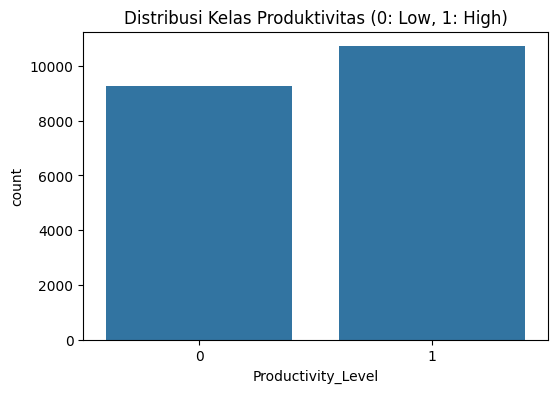

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribusi Kelas (Target)
plt.figure(figsize=(6, 4))
sns.countplot(x='Productivity_Level', data=df_class)
plt.title('Distribusi Kelas Produktivitas (0: Low, 1: High)')
plt.show()

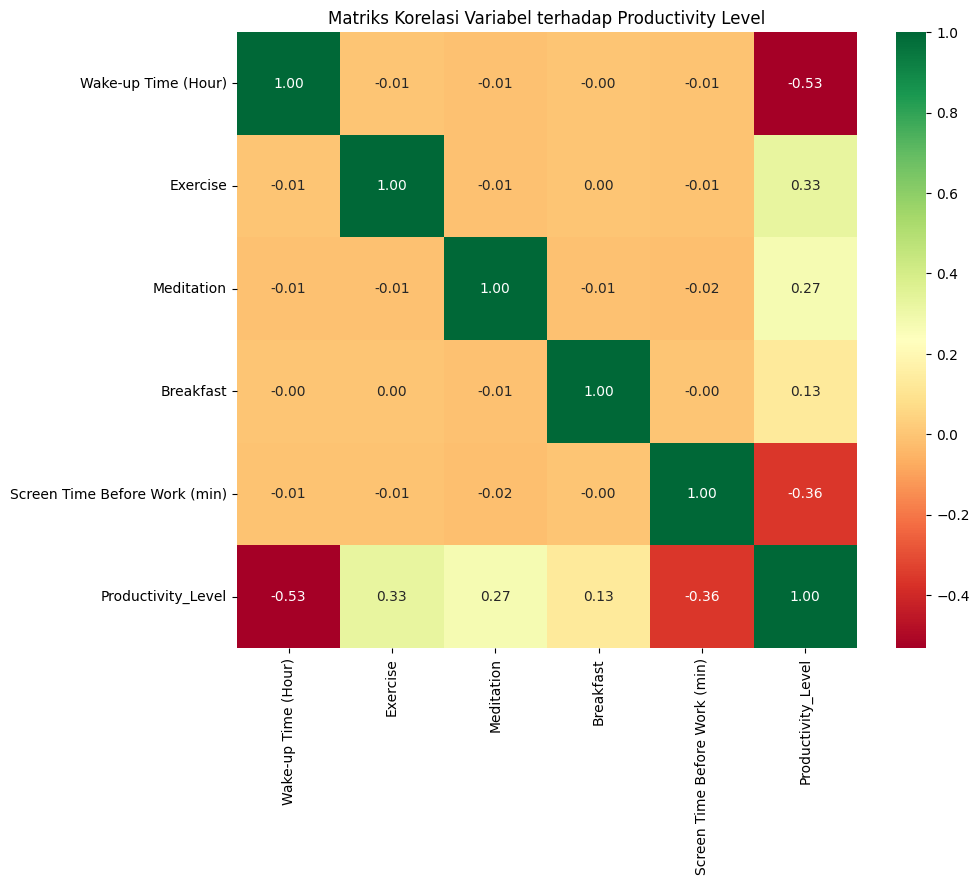

In [8]:
# 2. Matriks Korelasi (Melihat hubungan linear ke target klasifikasi)
plt.figure(figsize=(10, 8))
sns.heatmap(df_class.corr(), annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Matriks Korelasi Variabel terhadap Productivity Level')
plt.show()

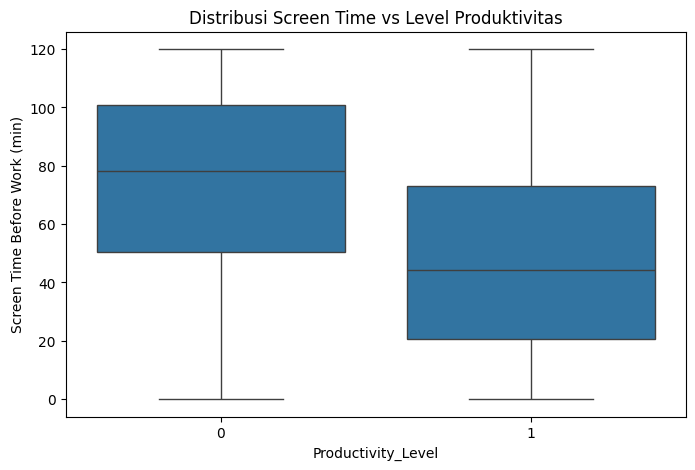

In [9]:
# 3. Boxplot: Perbandingan Screen Time Berdasarkan Level Produktivitas
plt.figure(figsize=(8, 5))
sns.boxplot(x='Productivity_Level', y='Screen Time Before Work (min)', data=df_class)
plt.title('Distribusi Screen Time vs Level Produktivitas')
plt.show()

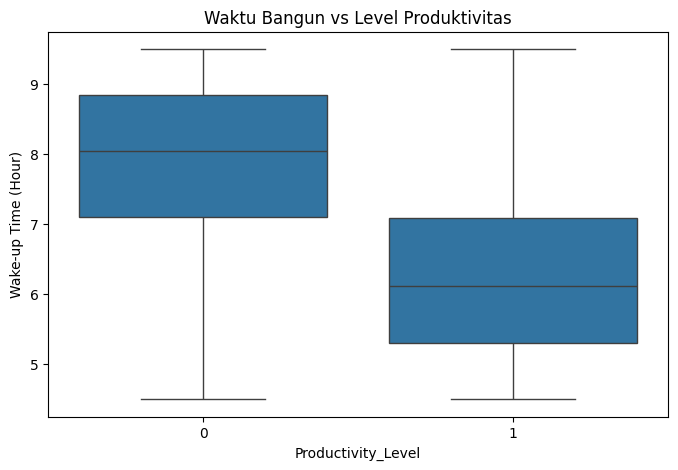

In [10]:
# 4. Boxplot: Perbandingan Waktu Bangun Berdasarkan Level Produktivitas
plt.figure(figsize=(8, 5))
sns.boxplot(x='Productivity_Level', y='Wake-up Time (Hour)', data=df_class)
plt.title('Waktu Bangun vs Level Produktivitas')
plt.show()

##4. Seleksi Fitur

In [11]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Memisahkan fitur dan target
X = df_class.drop('Productivity_Level', axis=1)
y = df_class['Productivity_Level']

# Metode 1: Mutual Information Score
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_results = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Metode 2: Random Forest Feature Importance
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X, y)
rf_importance = pd.Series(model_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Menampilkan hasil seleksi
print("Hasil Seleksi Fitur (Mutual Information):")
print(mi_results)
print("\nHasil Seleksi Fitur (Random Forest Importance):")
print(rf_importance)

Hasil Seleksi Fitur (Mutual Information):
Wake-up Time (Hour)              0.165643
Screen Time Before Work (min)    0.073121
Exercise                         0.055900
Meditation                       0.041971
Breakfast                        0.012327
dtype: float64

Hasil Seleksi Fitur (Random Forest Importance):
Wake-up Time (Hour)              0.455644
Screen Time Before Work (min)    0.288420
Exercise                         0.128537
Meditation                       0.096134
Breakfast                        0.031265
dtype: float64


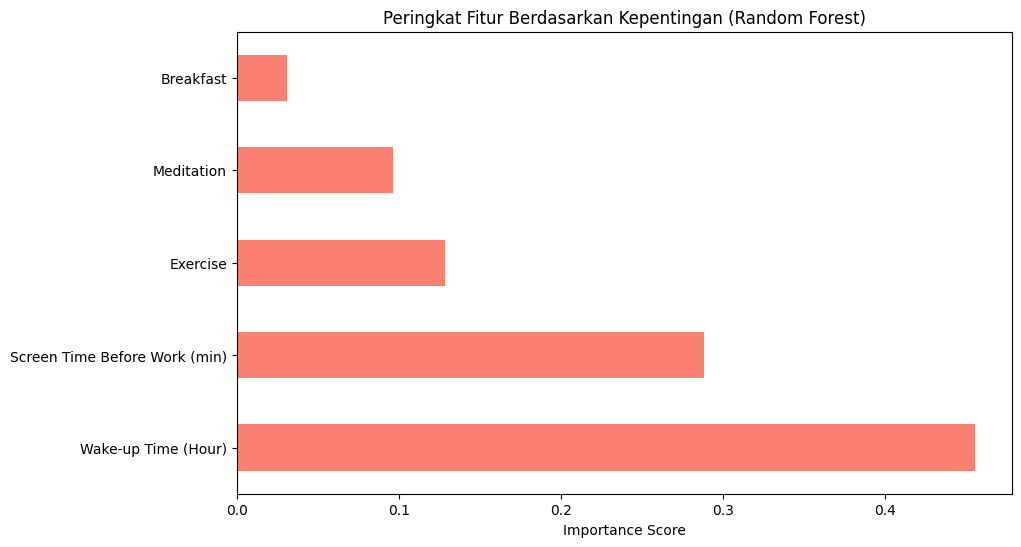

In [12]:
# Visualisasi Seleksi Fitur
plt.figure(figsize=(10, 6))
rf_importance.plot(kind='barh', color='salmon')
plt.title('Peringkat Fitur Berdasarkan Kepentingan (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

##5. Modeling

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Memisahkan fitur dan target
X = df_class.drop('Productivity_Level', axis=1)
y = df_class['Productivity_Level']

# Split data: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi dan Training Model Klasifikasi
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train, y_train)

print("Model Klasifikasi berhasil dilatih.")

Model Klasifikasi berhasil dilatih.


##6. Evaluasi Model & Analisis

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi data testing
y_pred = clf_model.predict(X_test)

# Menghitung Metrik
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"--- Hasil Evaluasi Model ---")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")

# Menampilkan Laporan Klasifikasi Lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- Hasil Evaluasi Model ---
Accuracy  : 0.9190
Precision : 0.9235
Recall    : 0.9244
F1-Score  : 0.9240

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1870
           1       0.92      0.92      0.92      2130

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



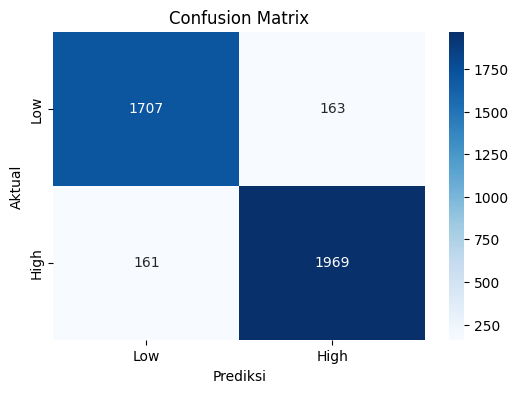

In [15]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

##7. Menyimpan Model

In [16]:
import joblib

# Menentukan nama file untuk menyimpan model
model_filename = 'model_produktivitas_rf.pkl'

# Menyimpan model ke dalam file
joblib.dump(clf_model, model_filename)

print(f"Model berhasil disimpan dengan nama: {model_filename}")

Model berhasil disimpan dengan nama: model_produktivitas_rf.pkl
